In [99]:
!pip install rioxarray
import dask.array as da
from pystac_client import Client
import leafmap
from datetime import datetime
import dask
import pystac_client
import planetary_computer as pc
import leafmap
import geogif
import numpy as np
import xarray as xr
import rioxarray
import geopandas as gpd

In [2]:
# Needs to be 0.5.0
# if it is not run "conda install -c conda-forge stackstac" in MPC terminal
#!pip install --upgrade stackstac==0.5.0 
import stackstac
stackstac.__version__

'0.5.0'

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jaandrews@clarku.edu/proxy/44125/status,
Dashboard: /user/jaandrews@clarku.edu/proxy/44125/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33997,Workers: 4
Dashboard: /user/jaandrews@clarku.edu/proxy/44125/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:35203,Total threads: 1
Dashboard: /user/jaandrews@clarku.edu/proxy/45201/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:44173,


In [4]:
api_url = "https://planetarycomputer.microsoft.com/api/stac/v1"


In [9]:
start_date = datetime(2008, 5, 1).isoformat()
end_date = datetime(2010, 8, 31).isoformat()


In [5]:
bbox = (-123.74286820900588, 36.79177481727697, -121.16108109963088, 38.82267288995824)=
bbox


(-123.74286820900588,
 36.79177481727697,
 -121.16108109963088,
 38.82267288995824)

In [42]:
m = leafmap.Map(center=[37.82, -122.39], zoom=10, height="800px")
m.add(bbox, color="red", weight=2, fill_opacity=0.1)
m


Map(center=[37.82, -122.39], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [12]:
catalog = pystac_client.Client.open(api_url)

search = catalog.search(
    datetime=f"{start_date}/{end_date}",
    collections=["landsat-c2-l2"],
    bbox=bbox,
    query=["eo:cloud_cover<5"],
    max_items=1000
)


In [13]:
%%time
items = pc.sign(search)
len(items)

CPU times: user 1.78 s, sys: 81.9 ms, total: 1.86 s
Wall time: 3.37 s


253

In [16]:
m.add_geojson(items.to_dict())
m

Map(bottom=101683.0, center=[37.82, -122.39], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

In [17]:
%%time
stack = stackstac.stack(items, bounds_latlon=bbox)
stack


CPU times: user 669 ms, sys: 0 ns, total: 669 ms
Wall time: 668 ms


<xarray.DataArray 'stackstac-40e924aa6db06c195846beed0c85f10f' (time: 253,
                                                                band: 19,
                                                                y: 7557, x: 7679)>
dask.array<fetch_raster_window, shape=(253, 19, 7557, 7679), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/28)
  * time                         (time) datetime64[ns] 2008-05-04T18:34:28.50...
    id                           (time) <U31 'LT05_L2SP_044033_20080504_02_T1...
  * band                         (band) <U13 'qa' 'red' ... 'atmos_opacity'
  * x                            (x) float64 4.337e+05 4.337e+05 ... 6.64e+05
  * y                            (y) float64 4.299e+06 4.299e+06 ... 4.072e+06
    platform                     (time) <U9 'landsat-5' ... 'landsat-5'
    ...                           ...
    landsat:correction           <U4 'L2SP'
    eo:cloud_cover               (time) float64 2.0 3.0 1.0 1.0 ... 0.0 0.0 3.0
    title                        (band) <U64 'Surface Temperature Quality Ass...
    raster:bands                 (band) object {'unit': 'kelvin', 'scale': 0....
    classification:bitfields     (band) object None None None ... None None
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(433710.0, 4072020.0, 664080.0...
    crs:         epsg:32610
    transform:   | 30.00, 0.00, 433710.00|\n| 0.00,-30.00, 4298730.00|\n| 0.0...
    resolution:  30.0

In [19]:
# Band names are not trivial from the initial query
stack.band


<xarray.DataArray 'band' (band: 19)>
array(['qa', 'red', 'blue', 'drad', 'emis', 'emsd', 'lwir', 'trad', 'urad',
       'atran', 'cdist', 'green', 'nir08', 'swir16', 'swir22', 'cloud_qa',
       'qa_pixel', 'qa_radsat', 'atmos_opacity'], dtype='<U13')
Coordinates:
  * band                       (band) <U13 'qa' 'red' ... 'atmos_opacity'
    description                (band) <U97 'Collection 2 Level-2 Quality Asse...
    proj:epsg                  int64 32610
    landsat:collection_number  <U2 '02'
    view:off_nadir             int64 0
    landsat:wrs_type           <U1 '2'
    gsd                        int64 30
    landsat:correction         <U4 'L2SP'
    title                      (band) <U64 'Surface Temperature Quality Asses...
    raster:bands               (band) object {'unit': 'kelvin', 'scale': 0.01...
    classification:bitfields   (band) object None None None ... None None
    epsg                       int64 32610

In [21]:
stack.sel(band=["nir08", "swir16"])


<xarray.DataArray 'stackstac-40e924aa6db06c195846beed0c85f10f' (time: 253,
                                                                band: 2,
                                                                y: 7557, x: 7679)>
dask.array<getitem, shape=(253, 2, 7557, 7679), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/28)
  * time                         (time) datetime64[ns] 2008-05-04T18:34:28.50...
    id                           (time) <U31 'LT05_L2SP_044033_20080504_02_T1...
  * band                         (band) <U13 'nir08' 'swir16'
  * x                            (x) float64 4.337e+05 4.337e+05 ... 6.64e+05
  * y                            (y) float64 4.299e+06 4.299e+06 ... 4.072e+06
    platform                     (time) <U9 'landsat-5' ... 'landsat-5'
    ...                           ...
    landsat:correction           <U4 'L2SP'
    eo:cloud_cover               (time) float64 2.0 3.0 1.0 1.0 ... 0.0 0.0 3.0
    title                        (band) <U64 'Near Infrared Band 0.8' 'Short-...
    raster:bands                 (band) object {'scale': 2.75e-05, 'nodata': ...
    classification:bitfields     (band) object None None
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(433710.0, 4072020.0, 664080.0...
    crs:         epsg:32610
    transform:   | 30.00, 0.00, 433710.00|\n| 0.00,-30.00, 4298730.00|\n| 0.0...
    resolution:  30.0

In [23]:
# Make a bitmask---when we bitwise-and it with the data, it leaves just the 4 bits we care about
mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

bin(bitmask)

'0b11110'

In [25]:
qa = stack.sel(band="qa_pixel").astype("uint16")
bad = qa & bitmask  # just look at those 4 bits

good = stack.where(bad == 0)  # mask pixels where any one of those bits are set


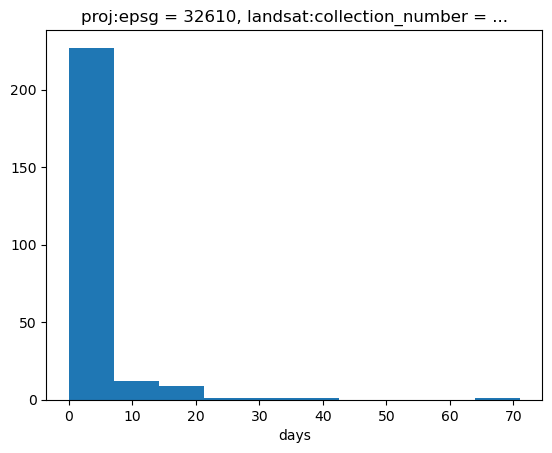

In [26]:
# What's the typical interval between scenes?
good.time.diff("time").dt.days.plot.hist();


In [71]:
good

<xarray.DataArray 'stackstac-40e924aa6db06c195846beed0c85f10f' (time: 253,
                                                                band: 19,
                                                                y: 7557, x: 7679)>
dask.array<where, shape=(253, 19, 7557, 7679), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * time                         (time) datetime64[ns] 2008-05-04T18:34:28.50...
    id                           (time) <U31 'LT05_L2SP_044033_20080504_02_T1...
  * band                         (band) <U13 'qa' 'red' ... 'atmos_opacity'
  * x                            (x) float64 4.337e+05 4.337e+05 ... 6.64e+05
  * y                            (y) float64 4.299e+06 4.299e+06 ... 4.072e+06
    platform                     (time) <U9 'landsat-5' ... 'landsat-5'
    ...                           ...
    landsat:wrs_type             <U1 '2'
    landsat:wrs_row              (time) <U3 '033' '033' '033' ... '035' '033'
    gsd                          int64 30
    landsat:correction           <U4 'L2SP'
    eo:cloud_cover               (time) float64 2.0 3.0 1.0 1.0 ... 0.0 0.0 3.0
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(433710.0, 4072020.0, 664080.0...
    crs:         epsg:32610
    transform:   | 30.00, 0.00, 433710.00|\n| 0.00,-30.00, 4298730.00|\n| 0.0...
    resolution:  30.0

In [90]:
nir = good.sel(band="nir08")
swir = good.sel(band="swir16")
nbr = (nir-swir)/(nir+swir)
nbr

<xarray.DataArray 'stackstac-40e924aa6db06c195846beed0c85f10f' (time: 253,
                                                                y: 7557, x: 7679)>
dask.array<truediv, shape=(253, 7557, 7679), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/23)
  * time                         (time) datetime64[ns] 2008-05-04T18:34:28.50...
    id                           (time) <U31 'LT05_L2SP_044033_20080504_02_T1...
  * x                            (x) float64 4.337e+05 4.337e+05 ... 6.64e+05
  * y                            (y) float64 4.299e+06 4.299e+06 ... 4.072e+06
    platform                     (time) <U9 'landsat-5' ... 'landsat-5'
    view:sun_azimuth             (time) float64 133.0 133.0 ... 132.7 139.7
    ...                           ...
    landsat:wrs_type             <U1 '2'
    landsat:wrs_row              (time) <U3 '033' '033' '033' ... '035' '033'
    gsd                          int64 30
    landsat:correction           <U4 'L2SP'
    eo:cloud_cover               (time) float64 2.0 3.0 1.0 1.0 ... 0.0 0.0 3.0
    epsg                         int64 32610

In [73]:
EucList= gpd.read_file("Euc/EucInFires.shp")
EucList.head()

,FIRE_NAME,Acres,NAME,ALARM_DATE,CONT_DATE,GIS_ACRES,Shape_Leng,Shape_Area,geometry
0,37,5.279167,Sonoma,2017-10-09,2017-10-16,1613.22000,3946.219117,2.299605e+05,MULTIPOLYGON Z (((5990130.904 2249482.096 0.00...
1,AMIGAS,0.110590,Napa,2013-07-04,2013-07-04,10.29020,334.629404,4.817311e+03,"POLYGON Z ((6034580.004 2276638.308 0.000, 603..."
2,BODEGA,2.818281,Sonoma,2017-08-27,2017-08-28,17.76830,2531.211383,1.227643e+05,"POLYGON Z ((5923224.845 2288231.750 0.000, 592..."
3,BRUNO,0.013076,San Mateo,2020-02-28,2020-02-28,6.78967,272.475055,5.696045e+02,"POLYGON Z ((6002406.512 2084460.753 0.000, 600..."
4,CZU LIGHTNING COMPLEX,69.431689,San Mateo,2020-08-16,2020-09-24,86553.50000,42874.190378,3.024444e+06,MULTIPOLYGON Z (((6090441.997 1842659.397 0.00...


In [74]:
# Filter to only vegetation patches > 5 acres
EucList= EucList[EucList['Acres']>5]
EucList

,FIRE_NAME,Acres,NAME,ALARM_DATE,CONT_DATE,GIS_ACRES,Shape_Leng,Shape_Area,geometry
0,37,5.279167,Sonoma,2017-10-09,2017-10-16,1613.2200,3946.219117,2.299605e+05,MULTIPOLYGON Z (((5990130.904 2249482.096 0.00...
4,CZU LIGHTNING COMPLEX,69.431689,San Mateo,2020-08-16,2020-09-24,86553.5000,42874.190378,3.024444e+06,MULTIPOLYGON Z (((6090441.997 1842659.397 0.00...
8,FREEDOM,5.734178,Santa Cruz,2021-01-19,2021-01-22,33.2592,3707.224165,2.497808e+05,MULTIPOLYGON Z (((6172085.718 1817620.840 0.00...
9,GLASS,10.910045,Sonoma,2020-09-27,2020-10-20,67484.4000,9747.424033,4.752416e+05,MULTIPOLYGON Z (((5965904.851 2354884.223 0.00...
10,HIGHWAY,10.264864,Contra Costa,2004-06-25,2004-06-28,624.9360,12261.731480,4.471375e+05,MULTIPOLYGON Z (((6090528.299 2193570.325 0.00...
11,KINCADE,13.084406,Sonoma,2019-10-23,2019-11-10,77762.1000,14191.818034,5.699567e+05,MULTIPOLYGON Z (((5913719.663 2388548.947 0.00...
13,LAKEVILLE,6.938177,Sonoma,2020-06-05,2020-06-05,159.6800,7403.997327,3.022270e+05,MULTIPOLYGON Z (((5980165.795 2262294.760 0.00...
14,NUNS,44.529154,Sonoma,2017-10-08,2017-10-31,55798.2000,33839.381530,1.939690e+06,MULTIPOLYGON Z (((6016849.161 2286287.667 0.00...
17,PRESSLEY,5.759141,Sonoma,2017-10-08,2017-10-15,791.8880,6586.776623,2.508682e+05,MULTIPOLYGON Z (((5948109.653 2327090.079 0.00...
19,SCENIC,25.442071,Contra Costa,2022-06-23,2022-06-23,120.4980,10729.477437,1.108257e+06,MULTIPOLYGON Z (((6075711.944 2208069.305 0.00...


In [82]:
# Read in Fire shapefiles with veg class erased
FireList= gpd.read_file("Fires/FiresErase.shp")
FireList.head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,COMPLEX_NA,COMPLEX_IN,IRWINID,Shape_Leng,Shape_Area,geometry
0,2020,CA,CDF,CZU,CZU LIGHTNING COMPLEX,00005205,2020-08-16,2020-09-24,1,NaN,86553.50000,7,1,NaN,CZU LIGHTNING COMPLEX,00005205,NaN,255052.193260,5.523185e+08,MULTIPOLYGON Z (((-13595243.987 4443010.352 0....
1,2020,CA,CDF,SCU,SCU COMPLEX,00005740,2020-08-16,2020-09-11,1,NaN,396824.00000,2,1,NaN,SCU COMPLEX,00005740,NaN,634336.338846,2.545884e+09,MULTIPOLYGON Z (((-13565935.502 4511434.333 0....
2,2020,CA,CDF,CZU,BRUNO,00001332,2020-02-28,2020-02-28,7,NaN,6.78967,1,1,NaN,NaN,NaN,NaN,915.539070,4.396858e+04,"POLYGON Z ((-13629208.910 4537644.964 0.000, -..."
3,2005,CA,CDF,SCU,TESLA,00002920,2005-07-19,2005-07-20,7,NaN,6440.36000,2,1,00000171,NaN,NaN,NaN,50941.358961,4.165893e+07,MULTIPOLYGON Z (((-13535155.596 4532891.027 0....
4,2005,CA,CDF,SCU,KOOPMAN,00003058,2005-07-26,2005-07-26,7,NaN,395.24600,1,1,10000094,NaN,NaN,NaN,9800.968065,2.553179e+06,"POLYGON Z ((-13564346.002 4525963.577 0.000, -..."


In [ ]:
## I thought this would work to subtract veg areas from fire perimeters, but its not working
## I did it in arc pro instead with the Erase module
# Merge vegetation polygons into a single geometry using unary_union
#vegetation_union = unary_union(EucList['geometry'])

# Subtract vegetation_union from all fire perimeters in 'FireList'
#modified_firelist = FireList.copy()
#modified_firelist['geometry'] = FireList['geometry'].difference(vegetation_union)


In [83]:
# Select observations in 'FireList' where 'FIRE_NAME' is in 'EucList'
FireList = FireList[FireList['FIRE_NAME'].isin(EucList['FIRE_NAME'])]
FireList

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,COMPLEX_NA,COMPLEX_IN,IRWINID,Shape_Leng,Shape_Area,geometry
0,2020,CA,CDF,CZU,CZU LIGHTNING COMPLEX,00005205,2020-08-16,2020-09-24,1,NaN,86553.5000,7,1,NaN,CZU LIGHTNING COMPLEX,00005205,NaN,255052.193260,5.523185e+08,MULTIPOLYGON Z (((-13595243.987 4443010.352 0....
5,2008,CA,CDF,CZU,TRABING,005581,2008-06-20,2008-06-22,10,75 structures destroyed,594.2640,1,1,NaN,NaN,NaN,NaN,9660.221753,3.771622e+06,MULTIPOLYGON Z (((-13560549.719 4430486.394 0....
10,2004,CA,NPS,GNP,TAM,00000003,2004-05-09,2004-05-18,14,NaN,11.7914,1,1,00000003,NaN,NaN,NaN,2311.579521,7.672831e+04,MULTIPOLYGON Z (((-13642231.479 4562749.382 0....
13,2021,CA,CDF,CZU,FREEDOM,00000489,2021-01-19,2021-01-22,11,NaN,33.2592,1,1,NaN,NaN,NaN,NaN,4130.554410,2.112959e+05,MULTIPOLYGON Z (((-13562951.948 4435548.531 0....
17,2020,CA,CDF,LNU,GLASS,00015497,2020-09-27,2020-10-20,14,J. Baldwin,67484.4000,7,1,NaN,NaN,NaN,NaN,272074.173454,4.470432e+08,MULTIPOLYGON Z (((-13643862.670 4640587.076 0....
18,2020,CA,CDF,LNU,LAKEVILLE,00008347,2020-06-05,2020-06-05,2,Brandon Bertolino,159.6800,6,1,NaN,NaN,NaN,NaN,4456.877916,1.048804e+06,MULTIPOLYGON Z (((-13643020.510 4612315.971 0....
21,2004,CA,CDF,SCU,HIGHWAY,00003485,2004-06-25,2004-06-28,2,NaN,624.9360,1,1,00000181,NaN,NaN,NaN,10317.778914,4.080267e+06,MULTIPOLYGON Z (((-13596166.783 4580531.363 0....
23,2013,CA,CDF,LNU,LAKEVILLE,00006147,2013-07-26,2013-07-27,2,NaN,177.8440,2,1,NaN,NaN,NaN,NaN,8412.064209,1.166756e+06,MULTIPOLYGON Z (((-13639239.805 4606030.608 0....
26,2017,CA,CDF,LNU,NUNS,00010049,2017-10-08,2017-10-31,14,"Nuns,Partrick, Adobe, Norrbom and Pressley mer...",55798.2000,3,1,NaN,SOUTHERN LNU COMPLEX,00010105,NaN,305483.095957,3.680012e+08,MULTIPOLYGON Z (((-13643554.731 4638510.340 0....
27,2017,CA,CDF,LNU,PRESSLEY,00010049,2017-10-08,2017-10-15,14,Merged into Nuns,791.8880,7,1,NaN,SOUTHERN LNU COMPLEX,00010105,NaN,22361.236288,5.220480e+06,"POLYGON Z ((-13650997.823 4632998.507 0.000, -..."


<Axes: >

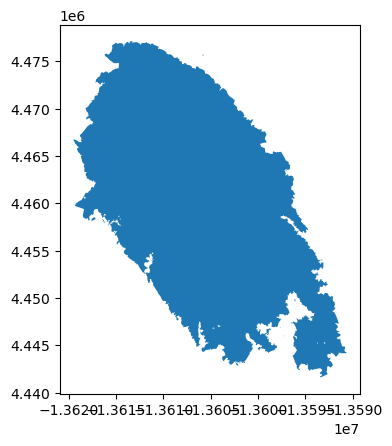

In [92]:
FireList.head(1).plot()

In [85]:
# Sort both GeoDataFrames by 'FIRE_NAME'
FireList_sorted = FireList.sort_values(by='FIRE_NAME')
EucList_sorted = EucList.sort_values(by='FIRE_NAME')

# Set 'FIRE_NAME' as the index for both GeoDataFrames
FireList_sorted = FireList_sorted.set_index('FIRE_NAME')
EucList_sorted = EucList_sorted.set_index('FIRE_NAME')
EucList_sorted.head()

,Acres,NAME,ALARM_DATE,CONT_DATE,GIS_ACRES,Shape_Leng,Shape_Area,geometry
FIRE_NAME,,,,,,,,
37,5.279167,Sonoma,2017-10-09,2017-10-16,1613.2200,3946.219117,2.299605e+05,MULTIPOLYGON Z (((5990130.904 2249482.096 0.00...
CZU LIGHTNING COMPLEX,69.431689,San Mateo,2020-08-16,2020-09-24,86553.5000,42874.190378,3.024444e+06,MULTIPOLYGON Z (((6090441.997 1842659.397 0.00...
FREEDOM,5.734178,Santa Cruz,2021-01-19,2021-01-22,33.2592,3707.224165,2.497808e+05,MULTIPOLYGON Z (((6172085.718 1817620.840 0.00...
GLASS,10.910045,Sonoma,2020-09-27,2020-10-20,67484.4000,9747.424033,4.752416e+05,MULTIPOLYGON Z (((5965904.851 2354884.223 0.00...
HIGHWAY,10.264864,Contra Costa,2004-06-25,2004-06-28,624.9360,12261.731480,4.471375e+05,MULTIPOLYGON Z (((6090528.299 2193570.325 0.00...


In [100]:
FireList_sorted.head()

,YEAR_,STATE,AGENCY,UNIT_ID,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,COMPLEX_NA,COMPLEX_IN,IRWINID,Shape_Leng,Shape_Area,geometry
FIRE_NAME,,,,,,,,,,,,,,,,,,,
37,2017,CA,CDF,LNU,00002957,2017-10-09,2017-10-16,11,LFB8. DIGITIZED FROM DIGITALGLOBE (MAXAR) IMA...,1613.2200,4,1,NaN,NaN,NaN,F570C977-2D96-4BB0-A146-52D1A32FA87D,46336.050945,1.057459e+07,MULTIPOLYGON Z (((-13633458.302 4598796.491 0....
CZU LIGHTNING COMPLEX,2020,CA,CDF,CZU,00005205,2020-08-16,2020-09-24,1,NaN,86553.5000,7,1,NaN,CZU LIGHTNING COMPLEX,00005205,NaN,255052.193260,5.523185e+08,MULTIPOLYGON Z (((-13595243.987 4443010.352 0....
FREEDOM,2021,CA,CDF,CZU,00000489,2021-01-19,2021-01-22,11,NaN,33.2592,1,1,NaN,NaN,NaN,NaN,4130.554410,2.112959e+05,MULTIPOLYGON Z (((-13562951.948 4435548.531 0....
GLASS,2020,CA,CDF,LNU,00015497,2020-09-27,2020-10-20,14,J. Baldwin,67484.4000,7,1,NaN,NaN,NaN,NaN,272074.173454,4.470432e+08,MULTIPOLYGON Z (((-13643862.670 4640587.076 0....
HIGHWAY,2004,CA,CDF,SCU,00003485,2004-06-25,2004-06-28,2,NaN,624.9360,1,1,00000181,NaN,NaN,NaN,10317.778914,4.080267e+06,MULTIPOLYGON Z (((-13596166.783 4580531.363 0....


<Axes: >

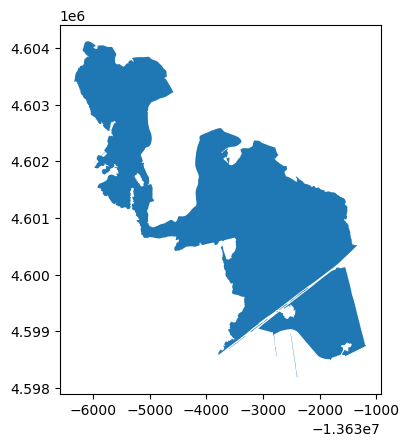

In [93]:
FireList_sorted.head(1).plot()

In [112]:
# Assuming 'EucList_sorted' has a defined CRS
nbr.rio.write_crs(EucList_sorted.crs)

# Select the first item in 'FireList_sorted'
first_fire_perimeter = FireList_sorted.iloc[0]['geometry']

# Set the CRS explicitly for the DataArray
nbr.rio.set_crs(EucList_sorted.crs, inplace=True)

# Clip the DataArray to the extent of the first fire perimeter
nbr_clipped = nbr.rio.clip(first_fire_perimeter)

# Now 'nbr_clipped' contains the clipped DataArray


TypeError: 'MultiPolygon' object is not iterable

In [106]:
FireList_sorted.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [107]:
EucList_sorted.crs

<Projected CRS: EPSG:6420>
Name: NAD83(2011) / California zone 3 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Alameda; Calaveras; Contra Costa; Madera; Marin; Mariposa; Merced; Mono; San Francisco; San Joaquin; San Mateo; Santa Clara; Santa Cruz; Stanislaus; Tuolumne.
- bounds: (-123.02, 36.73, -117.83, 38.71)
Coordinate Operation:
- name: SPCS83 California zone 3 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<xarray.DataArray 'stackstac-40e924aa6db06c195846beed0c85f10f' (time: 253,
                                                                y: 7557, x: 7679)>
dask.array<truediv, shape=(253, 7557, 7679), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * time                         (time) datetime64[ns] 2008-05-04T18:34:28.50...
    id                           (time) <U31 'LT05_L2SP_044033_20080504_02_T1...
  * x                            (x) float64 4.337e+05 4.337e+05 ... 6.64e+05
  * y                            (y) float64 4.299e+06 4.299e+06 ... 4.072e+06
    platform                     (time) <U9 'landsat-5' ... 'landsat-5'
    view:sun_azimuth             (time) float64 133.0 133.0 ... 132.7 139.7
    ...                           ...
    landsat:wrs_row              (time) <U3 '033' '033' '033' ... '035' '033'
    gsd                          int64 30
    landsat:correction           <U4 'L2SP'
    eo:cloud_cover               (time) float64 2.0 3.0 1.0 1.0 ... 0.0 0.0 3.0
    epsg                         int64 32610
    spatial_ref                  int64 0